# DeepBirb with TensorFlow

__*Robert Arbon*__

This notebook uses Google's DeepDream algorithm to modify  birdsong and images of birds. 

The modification of the images of birds is done via Google's __Deep Dream__ algorithm. The modification of the bird song is done by turning the bird song into an image and then using the __Deep Dream__ algorithm again. 

This notebook is based on the Google Colab seed by  ___Alex Mordvintsev___ called __DeepDream with TensorFlow__.  You can use the original [here](https://research.google.com/seedbank/seed/deepdream).

## Import libraries
To start with we're going to import all the libraries we will need.  Importing libraries at the start is standard practice as it allo

The pretrained Inception network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). This next cell downloads the file automatically and unpacks it locally to the Colab kernel. We can the load the contained model file  'tensorflow_inception_graph.pb' in the cell below.

In [1]:
from io import BytesIO

## Numerical computing modules
import numpy as np # Working with arrays of numbers
import tensorflow as tf # Working with arrays of numbers and the neural nets

## Image modules
import PIL.Image # Python Image Library for working with images
import IPython.display # Allows you to view and listen to files
from IPython.display import clear_output, Image, display

## Audio modules
!pip install librosa # install librosa module
import librosa # Librosa for audio processing
import librosa.display

## Graphing modules
import matplotlib.pyplot as plt # can create charts and other images

## Miscellaneous
from __future__ import print_function # for compatability with Python 2



## Download files

This section downloads files from the web on to the server running this notebook (i.e. somewhere at `colab.research.google.com`).  The '!' at the start of each line indicates that we're switching from using the `Python` programming language to using `bash`.  `bash` is good for file manipulations on Unix/Linux machines (most servers are Linux).



In [2]:
image_url="https://www.livingwithbirds.com/images/web/tweetapedia/21-facts-on-tawny-owl/21-facts-on-tawny-owl-i1.jpg"
# audio_url="https://www.xeno-canto.org/sounds/uploaded/OKHOSXCBNN/XC457074-tawny%20xeno%20good%20xy.mp3"
image_classifier_url="https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"


# !wget -nc -O my_audio.mp3 $audio_url
!wget -O my_image.jpeg $image_url
!wget -nc --no-check-certificate $image_classifier_url


--2019-03-08 15:53:50--  https://www.livingwithbirds.com/images/web/tweetapedia/21-facts-on-tawny-owl/21-facts-on-tawny-owl-i1.jpg
Resolving www.livingwithbirds.com (www.livingwithbirds.com)... 95.172.14.243
Connecting to www.livingwithbirds.com (www.livingwithbirds.com)|95.172.14.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29109 (28K) [image/jpeg]
Saving to: ‘my_image.jpeg’

my_image.jpeg       100%[===================>]  28.43K  --.-KB/s    in 0s      

2019-03-08 15:53:51 (311 MB/s) - ‘my_image.jpeg’ saved [29109/29109]

--2019-03-08 15:53:53--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip  

## Build the image classifier

First we unzip the downloaded image classifier.  Then we build it.  Don't worry about this code, its very complicated!

In [3]:
!unzip -n inception5h.zip


Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


In [4]:
model_fn = 'tensorflow_inception_graph.pb'

## Creating TensorFlow session and loading the model

# Create a graph and a session
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

# Load the tensorflow inception graph file 
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

# Creates an 'input' layer that correctly adjusts the image for use with 
# the image classifier
t_input = tf.placeholder(np.float32, name='input') 
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

# This is a 'helper' function.  We'll use this later to identify layers
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

Instructions for updating:
Use tf.gfile.GFile.


## Deep dream: images

The __Deep Dream__ algorithm is below.  It is....complicated.  However it basically does the following: 





### Our image

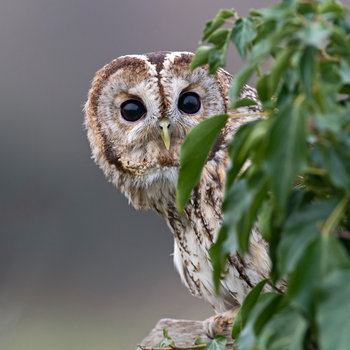

In [5]:
# This opens the image and loads it into the workbook
my_image = PIL.Image.open("my_image.jpeg")
# Just writing the variable name will show it:
my_image

### The algorithm

In [0]:
# These parameters let us control the strenth of the deepdream.
# octave_n = 4
# octave_scale = 1.4
# iter_n = 10
# strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, 
                     octave_n, octave_scale,
                     iter_n, strength, layer,
                     show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

In [0]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

### Load image and dream!

In [9]:
print(type(my_image))
before = sess.run(tf.convert_to_tensor(my_image))
print(type(before))
# showarray(before)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<type 'numpy.ndarray'>


In [0]:
octave_n = 10 #@param {type:"slider", max: 10}
octave_scale = 1 #@param {type:"number"}
iter_n = 20 #@param {type:"slider", max: 50}
strength = 156 #@param {type:"slider", max: 1000}
layer = "mixed3a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c","mixed5a"]

after = render_deepdream(tf.square(T(layer)), 
                         before, 
                        octave_n = octave_n,
                        octave_scale = octave_scale, 
                        iter_n = iter_n,
                        strength=strength, 
                        layer=layer)
